In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=7b961fff8d564aac234fc9a7af6ca2832c66a97c3201d5a7934184f3484bb3b4
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, count, col
import matplotlib.pyplot as plt
from pyspark.sql.functions import to_date, date_format
import pandas as pd
import numpy as np
from scipy import stats

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df = spark.read.format("csv").option("header", True).load("/content/Crime_Updated.csv")
print(df.dtypes)
df.printSchema()
df.show()

[('Town', 'string'), ('Year', 'string'), ('Crime Type', 'string'), ('Number of Crimes Committed', 'string'), ('Number of Crimes Committed per 100,000', 'string'), ('Crime ID', 'string'), ('State', 'string'), ('geometry', 'string')]
root
 |-- Town: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Crime Type: string (nullable = true)
 |-- Number of Crimes Committed: string (nullable = true)
 |-- Number of Crimes Committed per 100,000: string (nullable = true)
 |-- Crime ID: string (nullable = true)
 |-- State: string (nullable = true)
 |-- geometry: string (nullable = true)

+-------+----+--------------------+--------------------------+--------------------------------------+--------+-----+--------------------+
|   Town|Year|          Crime Type|Number of Crimes Committed|Number of Crimes Committed per 100,000|Crime ID|State|            geometry|
+-------+----+--------------------+--------------------------+--------------------------------------+--------+-----+-----------

In [8]:
df = df.withColumn("Year", year(df["Year"]))
df.show()
df.printSchema()


+-------+----+--------------------+--------------------------+--------------------------------------+--------+-----+--------------------+
|   Town|Year|          Crime Type|Number of Crimes Committed|Number of Crimes Committed per 100,000|Crime ID|State|            geometry|
+-------+----+--------------------+--------------------------+--------------------------------------+--------+-----+--------------------+
|Andover|2010|         Total Crime|                      35.0|                                1098.6|       0|   CT|POINT (-72.37036 ...|
|Andover|2010| Total Violent Crime|                       1.0|                                  31.4|       1|   CT|POINT (-72.37036 ...|
|Andover|2010|Total Property Crime|                      34.0|                                1067.2|       2|   CT|POINT (-72.37036 ...|
|Andover|2010|  Aggravated Assault|                       0.0|                                   0.0|       3|   CT|POINT (-72.37036 ...|
|Andover|2010|              Murder

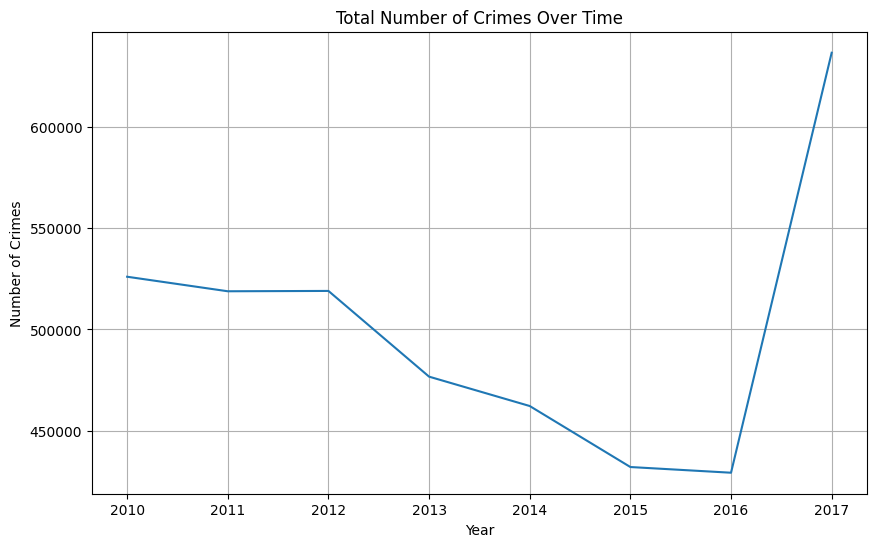

In [12]:
from pyspark.sql.types import FloatType
# Convert the 'Number of Crimes Committed' column to float type
df = df.withColumn("Number of Crimes Committed", df["Number of Crimes Committed"].cast(FloatType()))

# Aggregate the data by year and sum the number of crimes
yearly_crime_counts = df.groupBy("Year").sum("Number of Crimes Committed").orderBy("Year")

# Convert the aggregated DataFrame to Pandas DataFrame
yearly_crime_counts_pd = yearly_crime_counts.toPandas()

# Plotting the time series
plt.figure(figsize=(10, 6))
plt.plot(yearly_crime_counts_pd["Year"], yearly_crime_counts_pd["sum(Number of Crimes Committed)"])
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.title("Total Number of Crimes Over Time")
plt.grid(True)
plt.show()

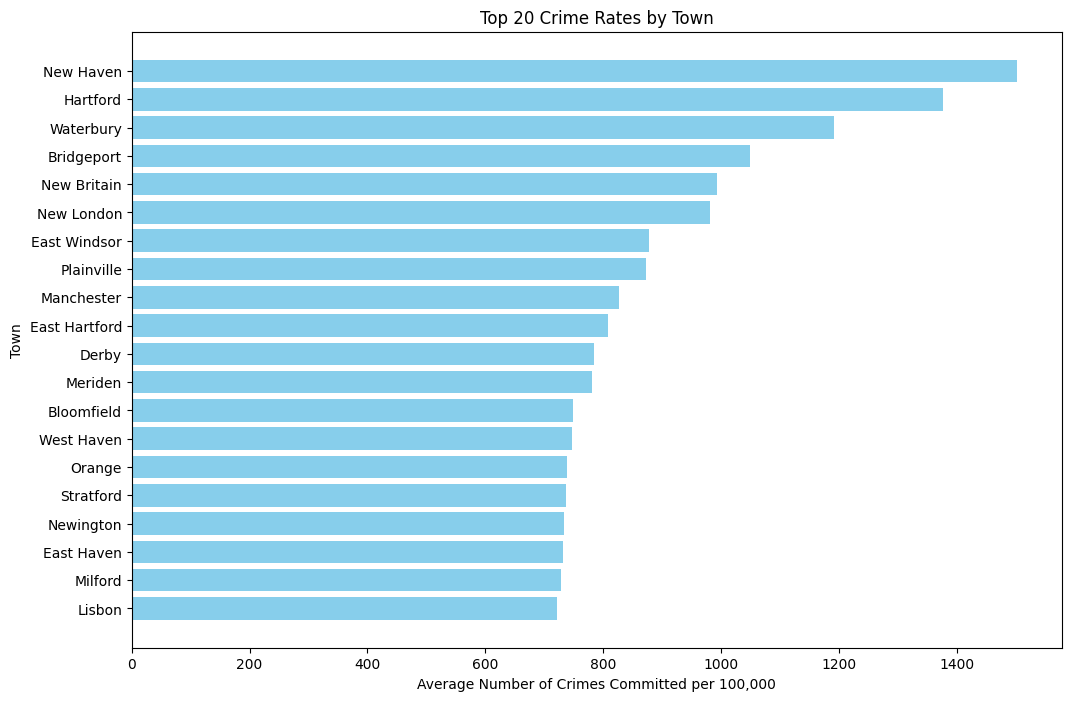

In [15]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

# Convert the column to FloatType
df = df.withColumn("Number of Crimes Committed per 100,000", col("Number of Crimes Committed per 100,000").cast(FloatType()))

# Group the data by town and calculate the average crime rate per town
town_crime_rates = df.groupBy("Town").avg("Number of Crimes Committed per 100,000").orderBy(col("avg(Number of Crimes Committed per 100,000)").desc())

# Select the top 20 towns
top_20_town_crime_rates = town_crime_rates.limit(20)

# Convert the aggregated DataFrame to Pandas DataFrame
top_20_town_crime_rates_pd = top_20_town_crime_rates.toPandas()

# Plotting the crime rates for the top 20 towns
plt.figure(figsize=(12, 8))
plt.barh(top_20_town_crime_rates_pd["Town"], top_20_town_crime_rates_pd["avg(Number of Crimes Committed per 100,000)"], color='skyblue')
plt.xlabel("Average Number of Crimes Committed per 100,000")
plt.ylabel("Town")
plt.title("Top 20 Crime Rates by Town")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest crime rate at the top
plt.show()



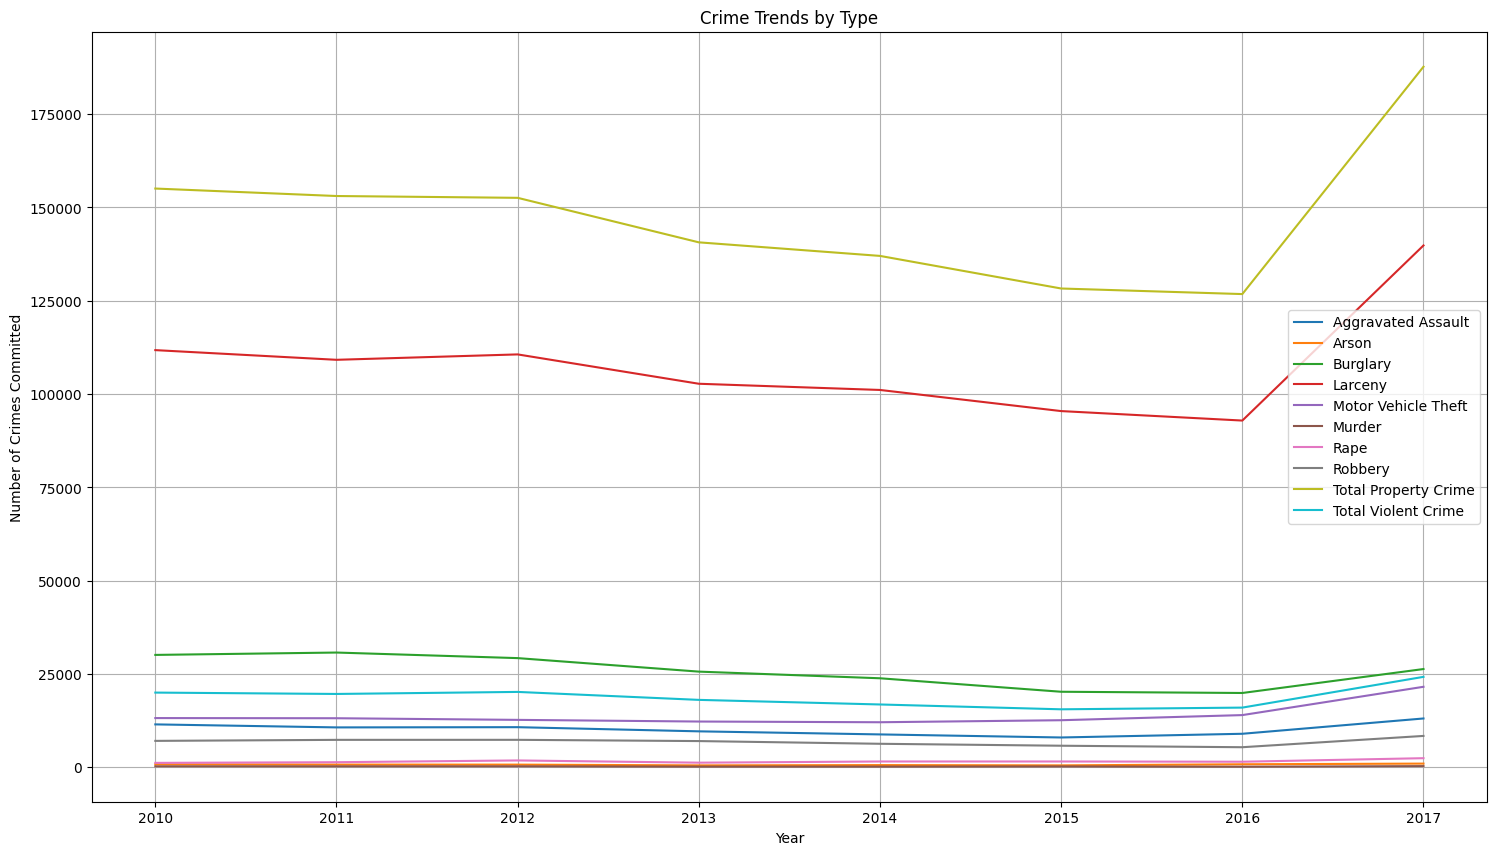

In [19]:
import matplotlib.pyplot as plt

# Filter out the total crime rows as we want to analyze individual crime types
crime_types_df = df.filter(df["Crime Type"] != "Total Crime")

# Group the data by crime type and year, then calculate the total number of crimes for each year
crime_trends = crime_types_df.groupBy("Crime Type", "Year").sum("Number of Crimes Committed").orderBy("Year")

# Convert the aggregated DataFrame to Pandas DataFrame
crime_trends_pd = crime_trends.toPandas()

# Pivot the data to have crime types as columns
crime_trends_pivot = crime_trends_pd.pivot(index='Year', columns='Crime Type', values='sum(Number of Crimes Committed)')

# Plotting the crime trends by type
plt.figure(figsize=(18, 10))
for column in crime_trends_pivot.columns:
    plt.plot(crime_trends_pivot.index, crime_trends_pivot[column], label=column)

plt.xlabel("Year")
plt.ylabel("Number of Crimes Committed")
plt.title("Crime Trends by Type")
plt.legend()
plt.grid(True)
plt.show()